In [6]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
import random
import torch

from torch.utils.tensorboard import SummaryWriter

from src.action import Action
from src.agent import Agent
from src.config import Config
from src.episode import Episode
from src.policy import Policy
from src.reward_model import RewardModel
from src.state import State
from src.utils import top_k_sampling
from src.world import World
import src.utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random agent action history
----

In [7]:
config = Config()
reward_model = RewardModel(config=config)
world_board = np.zeros(shape=(config.world_height, config.world_width))
world_board.shape

(20, 30)

In [3]:
episode = Episode.new(id="test")
episode.run_steps_by_random(steps=30)

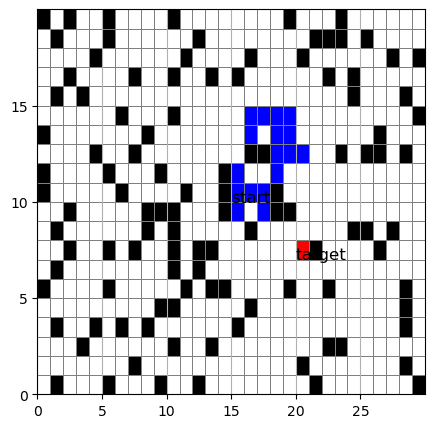

In [4]:
fig = plt.figure(figsize=config.figure_size)
ax = fig.add_subplot(1, 1, 1)
episode.viz(ax=ax)
plt.show()

# Policy Guide agent action history
----

In [8]:
episode = Episode.new(id="test")
policy = Policy(config=episode.config).to(episode.config.device)

episode.run_steps_by_policy(
    steps=20, policy=policy, top_k=episode.config.top_k, debug=True
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

step: 0, logits: tensor([[-0.3432, -0.2014,  0.7900, -0.2160, -0.2586,  0.0687, -0.6921, -0.0723,
         -0.1963]]), logit_prob: tensor([[0.1110]]), top_k_prob: tensor([[0.1592]]), action_idx: tensor([[7]]), state: tensor([0.5333, 0.5000])
step: 1, logits: tensor([[ 0.8857, -0.4826,  0.1084,  0.1153, -0.4585, -0.3255,  0.1966, -0.1983,
          0.2993]]), logit_prob: tensor([[0.1133]]), top_k_prob: tensor([[0.1542]]), action_idx: tensor([[2]]), state: tensor([0.5000, 0.5500])
step: 2, logits: tensor([[ 0.2690, -0.1051,  0.6092,  0.4786,  0.4426, -0.9121, -0.6686,  0.0318,
          0.0367]]), logit_prob: tensor([[0.1560]]), top_k_prob: tensor([[0.2500]]), action_idx: tensor([[2]]), state: tensor([0.4667, 0.6000])
step: 3, logits: tensor([[-0.2396,  0.0644,  0.2511,  0.0699,  0.5454, -0.6707, -0.5895, -0.7095,
          0.0613]]), logit_prob: tensor([[0.1239]]), top_k_prob: tensor([[0.1726]]), action_idx: tensor([[3]]), state: tensor([0.4667, 0.5500])
step: 4, logits: tensor([[-0.311

/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())


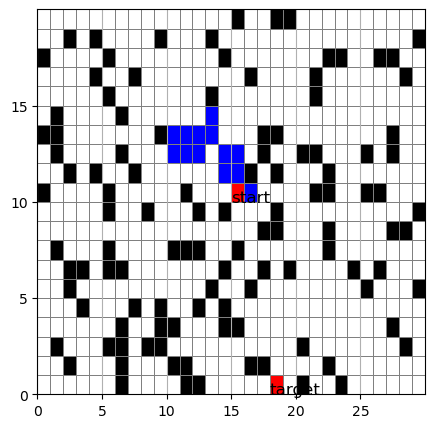

In [9]:
fig = plt.figure(figsize=config.figure_size)
ax = fig.add_subplot(1, 1, 1)
episode.viz(ax=ax)
plt.show()

# TRAIN Policy
----

In [10]:
def get_color(idx: int):
    colors = ["red", "green", "blue", "gray"]
    return colors[idx % len(colors)]


def train_and_plot_policy(policy: Policy, debug: bool = False):
    episode = Episode.new(id="train")
    print(f"start: {episode.agent.current_state}")
    episode.train(steps=20, policy=policy, debug=debug)
    print(f"start2: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, color=get_color(0))
    plt.show()

    return episode


def inference_and_plot_policy(policy: Policy, steps: int = 20, debug: bool = False):
    episode = Episode.new(id="inference")
    print(f"start state: {episode.agent.current_state}")
    episode.inference_steps_by_policy(steps=steps, policy=policy, debug=debug)
    print(f"end state: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, color=get_color(0))
    plt.show()

    return episode

In [ ]:
config = Config()

In [ ]:
policy = Policy(config=config).to(config.device)

episode = train_and_plot_policy(policy=policy, debug=True)
episode.agent.action_history

In [ ]:
policy = Policy(config=config).to(config.device)

episode = inference_and_plot_policy(policy=policy, debug=True)
episode.agent.action_history

In [ ]:
center_pos = torch.tensor([0, 80])
fov = episode.fov(center_pos=center_pos)
print(f"fov: {fov.size()}")
print(f"fov: {fov}")

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)
episode.world.viz_fov(center_pos=center_pos, ax=ax)
plt.show()

# Train Policy Model
----

In [ ]:
policy = Policy(config=config).to(config.device)

# GRPO
# 1. Generate samples from the same starting state (same query)
optimizer = torch.optim.AdamW(policy.parameters(), lr=1, weight_decay=0.01)
writer = SummaryWriter()

# for name, param in policy.brain[0].named_parameters():
#     print(name, param)

for iteration in range(10):
    # each episode iteration is always starting from the same state
    start_state = State.create_from(
        config=config,
        id=id,
        x=(config.world_min_x + config.world_max_x) // 2,
        y=(config.world_min_y + config.world_max_y) // 2,
    )
    target_state = State.create_from(
        config=config,
        id="earth",
        x=random.uniform(config.world_min_x, config.world_max_x),
        y=random.uniform(config.world_min_y, config.world_max_y),
    )

    episodes = []
    for episode_idx in range(config.episodes_per_iteration):
        episode = Episode.create_from_state(
            start_state=start_state, target_state=target_state
        )
        episode.train(steps=config.episode_steps, policy=policy, debug=False)
        episodes.append(episode)

    # 2. Compute the Advantages
    episodes_rewards = torch.tensor(
        [episode.reward() for episode in episodes], device=config.device
    )
    # print(f"episodes rewards: {episodes_rewards}")

    r_std, r_mean = torch.std_mean(episodes_rewards)
    writer.add_scalar("r_std", r_std, iteration)
    writer.add_scalar("r_mean", r_mean, iteration)
    if r_std == 0.0:
        # print(f"invalid episode, r_std: {r_std}")
        continue

    r_advantages = (episodes_rewards - r_mean) / r_std
    # print(f"r_std: {r_std}, r_mean: {r_mean}, r_advantages: {r_advantages}")

    # 3. Compute the KL-
    # N/A

    # 4. Compute weighted rewards
    advantage_weighted_rewards = episodes_rewards * r_advantages
    # print(f"advantage_weighted_rewards: {advantage_weighted_rewards}")

    episode_log_probs = torch.concat(
        [episode.log_reward_prob() for episode in episodes]
    ).to(config.device)
    # print(f"episode_log_probs: {episode_log_probs}")
    writer.add_histogram(f"episode_log_probs", episode_log_probs, iteration)

    episode_probs = torch.concat([episode.reward_prob() for episode in episodes])
    # print(f"episode_probs: {episode_probs}")
    writer.add_histogram(f"episode_probs", episode_probs, iteration)

    episode_weighted_rewards = (
        advantage_weighted_rewards * episode_log_probs
    )  # episode_probs
    # print(f"episode_weighted_rewards: {episode_weighted_rewards}")
    writer.add_histogram(
        f"episode_weighted_rewards", episode_weighted_rewards, iteration
    )

    mean_episode_weighted_rewards = torch.mean(episode_weighted_rewards)
    # print(f"mean_episode_weighted_rewards: {mean_episode_weighted_rewards}")
    writer.add_scalar(
        "mean_episode_weighted_rewards", mean_episode_weighted_rewards, iteration
    )

    # Debug
    # def _print_grad(grad):
    #     return
    #     print("Gradient:", grad)

    # for name, param in policy.brain[0].named_parameters():
    #     # print(name, param)
    #     param.register_hook(_print_grad)

    # Zero your gradients for every batch!
    optimizer.zero_grad()
    mean_episode_weighted_rewards.backward()
    # for name, param in policy.brain[0].named_parameters():
    #     print(name, param)

    # Adjust learning weights
    optimizer.step()

    for name, param in policy.brain.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f"{name}.grad", param.grad, iteration)

    # for name, param in policy.brain[0].named_parameters():
    #     print(name, param)

In [ ]:
episodes[0].log_reward_prob()
lrps = [episode.log_reward_prob() for episode in episodes]
torch.tensor(lrps)

In [ ]:
episode = inference_and_plot_policy(policy=policy, steps=100, debug=False)
# episode.agent.action_history, episode.reward()